# Simulation of linear inertial waves on the sphere

This notebook has been used for the study of A. Leclerc, G. Laibe and N. Perez. It simulates the propagation of linear solar inertial waves in the convective zone, analyzes the data and compute the winding number as defined in the paper. The robustness to the addition of noise is tested. The main loop takes ten minutes on an Intel Core i7 (4 cores) CPU.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm, colors
from IPython import display
import dedalus.public as d3
import time
import logging
logger = logging.getLogger(__name__)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["New Century Schoolbook"]
})

def simpleaxis(ax,xlabel,ylabel,rotation=0):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel(xlabel,size=12)
    ax.set_ylabel(ylabel,size=14,rotation=rotation)
    return ax

In [2]:
# Parameters
Nphi   = 64
Ntheta = 64

Omega = 1.0
S     = -800.0
R     = 0.02 

timestep      = 1e-2
stop_sim_time = 100

dtype = np.complex128

#initial conditions
h0     = 1
v0     = 1
σphi   = 0.5*2*np.pi   # initial perturbation's width in phi
σtheta = 0.5*np.pi     # initial perturbation's width in theta
phi0   = np.pi         # initial phi of center
theta0 = np.pi/2       # initial theta of center


print("dt / dt acoustic:",timestep/(2*np.pi*R/Nphi))
print("Pulsation resolution will be {:.4f}".format(2*np.pi/stop_sim_time))
print("Pulsation max will be {:.1f}".format(2*np.pi/timestep/2))

dt / dt acoustic: 5.09295817894065
Pulsation resolution will be 0.0628
Pulsation max will be 314.2


In [5]:
# Dedalus simulation base
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dtype=dtype)
phi, theta = dist.local_grids(basis)

2024-06-07 13:30:18,791 __main__ 0/1 INFO :: Iteration: 9901, Time: 9.901000e+01, dt: 1.000000e-02
Simulation will take ~ 4 s (0.0 h) to finish


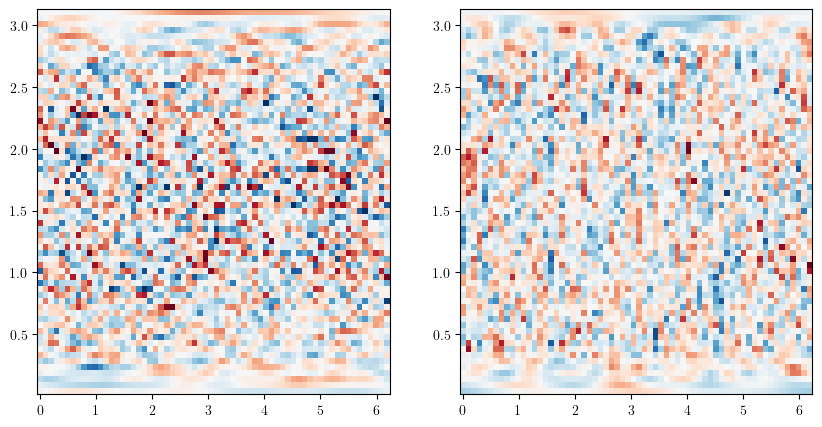

2024-06-07 13:30:22,760 solvers 0/1 INFO :: Simulation stop time reached.
Done


In [7]:
%matplotlib inline

# Fields for which to solve the evolution
u  = dist.VectorField(coords, name='u', bases=basis)
ur = dist.Field(name='ur', bases=basis)
h  = dist.Field(name='h',  bases=basis)

# Substitutions
zcross        = lambda A: d3.MulCosine(d3.skew(A))
ephi          = dist.VectorField(coords,name='ephi', bases=basis.latitude_basis)
ephi['g'][0]  = 1
sinTheta      = dist.Field(name='sinTheta',  bases=basis.latitude_basis)
sinTheta['g'] = np.sin(theta)

# Initial conditions
envelope   = np.exp(-(phi-phi0)**2/2/σphi**2 - (theta-theta0)**2/2/σtheta**2)
h['g']    += envelope*h0*(2*np.random.rand(Nphi,Ntheta)-1) 
ur['g']   += envelope*v0*(2*np.random.rand(Nphi,Ntheta)-1) 
u['g'][0] += envelope*v0*(2*np.random.rand(Nphi,Ntheta)-1) 
u['g'][1] += envelope*v0*(2*np.random.rand(Nphi,Ntheta)-1) 

# Problem
problem = d3.IVP([u, ur, h], namespace=locals())
problem.add_equation("dt(u)  + grad(h) + 2*Omega*zcross(u) +(2*Omega*sinTheta*ur)*ephi = 0 ")
problem.add_equation("dt(ur) - S*h -(2*Omega*sinTheta*u)@ephi = 0")
problem.add_equation("dt(h)  + div(u) + S*ur = 0")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Arrays for recording
data_p_txy  = [h['g'].copy()]
data_vx_txy = [u['g'][0].copy()]
data_vy_txy = [u['g'][1].copy()]
data_vz_txy = [ur['g'].copy()]
times       = [0.0]

# Main loop
phim, thetam = np.meshgrid(phi,theta)
fig, axis = plt.subplots(figsize=(3,3))
p = axis.pcolormesh(phim,thetam, np.real(h['g'].T), cmap='RdBu_r')
axis.set_title("Initial condition")
plt.show()

t0_step = time.time()
try:
    logger.info('Starting main loop')
    while solver.proceed: 
        
        #solving the time step
        solver.step(timestep)   
        
        #record
        times      +=[solver.sim_time]
        data_p_txy +=[h['g'].copy()]
        data_vx_txy+=[u['g'][0].copy()]
        data_vy_txy+=[u['g'][1].copy()]
        data_vz_txy+=[ur['g'].copy()]
        
        if (solver.iteration-1) % 100 == 0:
            # once in a while, plot a snapshot
            display.clear_output()
            
            t1_step = time.time()            
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, timestep))
            print("Simulation will take ~ {:.0f} s ({:.1f} h) to finish".format((stop_sim_time-solver.sim_time)/timestep*(t1_step-t0_step)/100,(stop_sim_time-solver.sim_time)/timestep*(t1_step-t0_step)/100/3600))
    
            # Update plot of scalar field
            fig, axis = plt.subplots(1,2,figsize=(5*2,5))
            p = axis[0].pcolormesh(phim,thetam, np.real(u['g'][0].T), vmin = -1, vmax=1, cmap='RdBu_r');
            p = axis[1].pcolormesh(phim,thetam, np.real(u['g'][1].T), vmin = -1, vmax=1, cmap='RdBu_r');
            plt.show()
            
            t0_step = time.time()

        
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
    
data_vx_txy = np.array(data_vx_txy)
data_vy_txy = -np.array(data_vy_txy) # vy = -vtheta
data_vz_txy = np.array(data_vz_txy)
data_p_txy  = np.array(data_p_txy)
times       = np.array(times)
    
phis   = phi.flatten()
thetas = theta.flatten()
sortThetas = np.argsort(thetas)

thetas = thetas[sortThetas]
data_vx_txy = data_vx_txy[:,:,sortThetas]
data_vy_txy = data_vy_txy[:,:,sortThetas]
data_vz_txy = data_vz_txy[:,:,sortThetas]
data_p_txy  = data_p_txy[:,:,sortThetas]  

print("Done")

### Plot snapshot 3D

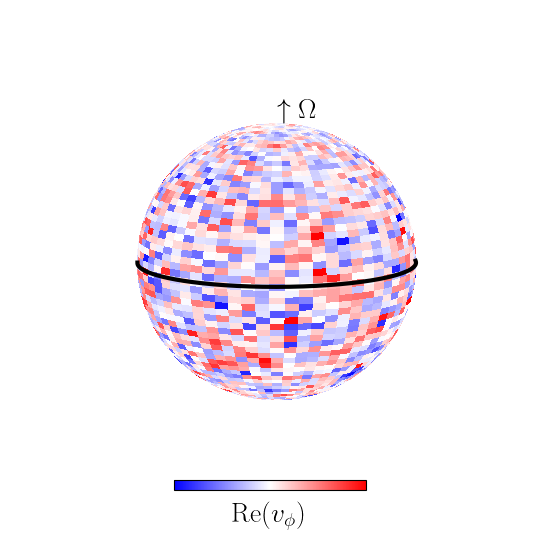

In [13]:
### Plot snapshot

rSphere    = 0.9
elev       = 10
azim       = 160
roll       = 0
luminosity = 0.7
figsize    = (5.5,5.5)
cmap       = cm.bwr

field = data_vx_txy[-1,:,:].real

phim,thetam = np.meshgrid(phis,thetas)
vmax = luminosity*np.max(np.abs(field))
norm=colors.Normalize(vmin = -vmax, vmax = vmax, clip = False)

fig = plt.figure(figsize=figsize)
x = rSphere * np.sin(thetam) * np.cos(phim)
y = rSphere * np.sin(thetam) * np.sin(phim)
z = rSphere * np.cos(thetam)

thetaEq = np.linspace(0+azim/360*2*np.pi/2*0.9,np.pi+azim/360*2*np.pi/2*0.9,500)
xEq = rSphere*np.cos(thetaEq)
yEq = rSphere*np.sin(thetaEq)
zEq = 0*thetaEq

ax = fig.add_subplot(111, projection='3d')
img = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cmap, linewidth=0, antialiased=False,facecolors=cmap(norm(field.T)))
ax.plot(xEq,yEq,zEq,color="black",lw=3,zorder=5)
ax.text(0,0,1.05*rSphere, r"$\uparrow \Omega$",fontsize=20)
ax.view_init(elev=elev, azim=azim, roll=roll)
ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())
ax.set_xlim((-1,1))
ax.set_box_aspect((1,1,0.9))
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis.set_pane_color((0.7, 0.7, 0.7, 0.0))
ax.yaxis.set_pane_color((0.7, 0.7, 0.7, 0.0))
ax.zaxis.set_pane_color((0.7, 0.7, 0.7, 0.0))
                   
cb = plt.colorbar(img,fraction=0.02,ticks=(),pad=-0.1,location="bottom")   
cb.set_label(r"$\mathrm{Re}(v_\phi)$",fontsize=20)
plt.tight_layout()
# plt.savefig("./snapshot_3d_sphere.png",bbox_inches='tight',dpi=900)
plt.show()

### Fourier transform

In [17]:
### full_transform computes the Fourier transform of cube(t,x,y), returns cube(omega,kx,ky)

def spectral_cube(cube,xs,ys,ts):
      
    #kx, ky and freqs (with signs convention of the paper)
    kxs    = np.fft.fftfreq(xs.size,d=np.diff(xs).mean())  
    kys    = -np.fft.fftfreq(ys.size,d=np.diff(ys).mean()) 
    freqs  = -np.fft.fftfreq(ts.size,d=np.diff(ts).mean()) 
    sortKxs       = np.argsort(kxs) 
    sortKys       = np.argsort(kys) 
    sortFreqs     = np.argsort(freqs) 
    kxs,kys,freqs = kxs[sortKxs],kys[sortKys],freqs[sortFreqs]

    #sort kx, ky  
    FT_bothspaces = np.fft.fft(np.fft.fft(cube,axis=2),axis=1)    
    tmp = FT_bothspaces[:,sortKxs,:]
    FT_bothspaces = tmp[:,:,sortKys]

    #TF time
    full_transform = np.fft.fft(FT_bothspaces,axis=0)

    #sort freqs
    full_transform = full_transform[sortFreqs,:,:]
        

    return full_transform, 2*np.pi*kxs, 2*np.pi*kys, 2*np.pi*freqs

In [16]:
# add artificial noise

def noised_fields(ampl_noise,data_vx,data_vy,data_vz):
    Nt,Nphi,Ntheta = data_vx.shape
    noise_vx = ampl_noise*(2*np.random.rand(Nt,Nphi,Ntheta)-1)
    noise_vy = ampl_noise*(2*np.random.rand(Nt,Nphi,Ntheta)-1)
    noise_vz = ampl_noise*(2*np.random.rand(Nt,Nphi,Ntheta)-1)

    full_vx = data_vx + noise_vx
    full_vy = data_vy + noise_vy
    full_vz = data_vz + noise_vz
    
    return full_vx,full_vy,full_vz

full_vx,full_vy,full_vz = noised_fields(0.0,data_vx_txy,data_vy_txy,data_vz_txy)

In [18]:
# Fourier transform of the data in a given latitude region
hemisphere = "north"

if hemisphere == "north":
    itheta0 = 0
    itheta1 = np.argmin(np.abs(thetas-np.pi/2))
    
elif hemisphere == "south":
    itheta0 = np.argmin(np.abs(thetas-np.pi/2))+1
    itheta1 = -1  
    
elif hemisphere == "equatorial":
    itheta0 = np.argmin(np.abs(thetas-0.25*np.pi))
    itheta1 = np.argmin(np.abs(thetas-0.75*np.pi))
    
else: 
    print("going for full sphere")
    itheta0 = 0
    itheta1 = -1
    
    
print("Calculation of spectral cube, hemisphere = ",hemisphere)
print("thetas : ",thetas[itheta0:itheta1])
t0 = time.time()
spectral_cube_vx, kxs, kys, freqs = spectral_cube(full_vx[:,:,itheta0:itheta1], phis, thetas[itheta0:itheta1], times)
spectral_cube_vy, kxs, kys, freqs = spectral_cube(full_vy[:,:,itheta0:itheta1], phis, thetas[itheta0:itheta1], times)
spectral_cube_vz, kxs, kys, freqs = spectral_cube(full_vz[:,:,itheta0:itheta1], phis, thetas[itheta0:itheta1], times)
t1 = time.time()
print("took {:.1f} s".format(t1-t0))

pow_spec = np.abs(spectral_cube_vx)**2 + np.abs(spectral_cube_vy)**2 + np.abs(spectral_cube_vz)**2

Calculation of spectral cube, hemisphere =  north
thetas :  [0.03728374 0.08558175 0.13416498 0.18281265 0.23148477 0.28016871
 0.32885927 0.37755388 0.42625117 0.47495031 0.52365078 0.57235225
 0.62105448 0.6697573  0.71846058 0.76716424 0.81586821 0.86457244
 0.91327687 0.96198148 1.01068624 1.05939113 1.10809611 1.15680119
 1.20550635 1.25421156 1.30291683 1.35162214 1.40032748 1.44903285
 1.49773823]
took 9.0 s


### Power spectrum

<IPython.core.display.Javascript object>


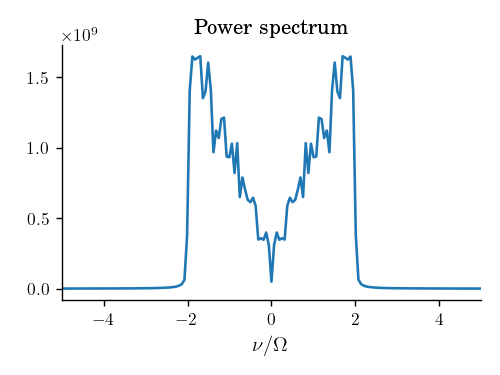

In [20]:
%matplotlib nbAgg

fig, ax = plt.subplots(figsize=(4,3))

ax = simpleaxis(ax,"","")

ax.plot(freqs,pow_spec.mean(axis=(1, 2)))
ax.set_title("Power spectrum")
ax.set_xlabel(r"$\nu/\Omega$")

ax.set_xlim((-5,5))

plt.tight_layout()
plt.show()

### Winding

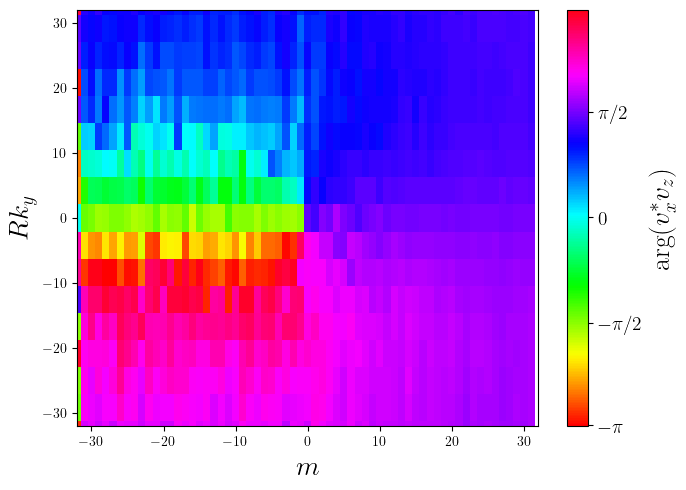

In [25]:
%matplotlib inline

def phase_upper_vx_vz(spectral_vx,spectral_vz,freqs):
    freqMin = 0.0
    freqMax = 2.0

    ifreq1 = np.argmin(np.abs(freqs-freqMin))
    ifreq2 = np.argmin(np.abs(freqs-freqMax))

    phase = np.angle(np.mean(np.conjugate(spectral_vx[ifreq1:ifreq2,:,:]) * spectral_vz[ifreq1:ifreq2,:,:],axis=0))
    
    return phase

freqMin = 0
freqMax = 2
        
field1 = spectral_cube_vx
field2 = spectral_cube_vz

ifreq1 = np.argmin(np.abs(freqs-freqMin))
ifreq2 = np.argmin(np.abs(freqs-freqMax))

kxsm, kysm = np.meshgrid(kxs,kys)

phase = np.angle(np.mean(np.conjugate(field1[ifreq1:ifreq2,:,:]) * field2[ifreq1:ifreq2,:,:],axis=0))
phase = phase_upper_vx_vz(spectral_cube_vx,spectral_cube_vz,freqs)

fig, ax = plt.subplots(figsize=(7,5))

img = ax.pcolormesh(kxsm, kysm, phase.T, cmap='hsv')
ax.set_xlabel(r"$m$",fontsize=20)
ax.set_ylabel(r"$R k_y$",fontsize=20)
plt.axis((-32,32,-32,32))
cb = plt.colorbar(img,ax=ax,ticks=[-3.1,-1.57,0,1.57,3.14])
cb.ax.set_yticklabels([r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
cb.ax.tick_params(labelsize=14)
cb.set_label(label=r"$\mathrm{arg}(v_x^* v_z)$", size=20)
plt.tight_layout()
plt.show()

### Measure of winding number
The chosen path is a square with corners in $(k_x,k_y)=(\pm k_{x0},\pm k_{y0})$. The winding is measured with the unwrapping procedure described in the paper.

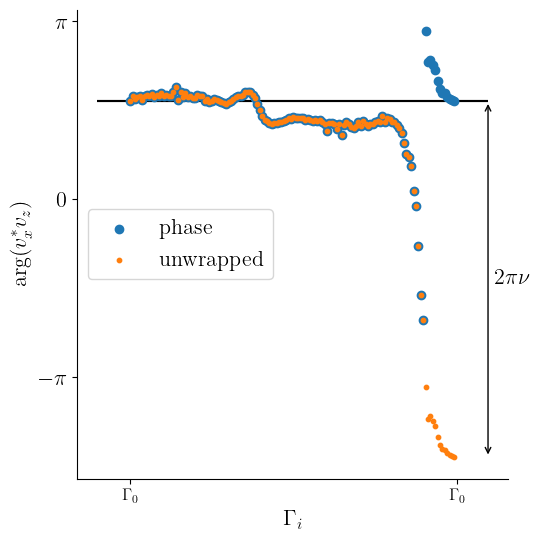

winding =  -1.0


In [30]:
def compute_winding(phase,kx0=20,ky0=40):
    iky0 = np.argmin(np.abs(kys-(-ky0)))
    ikx0 = np.argmin(np.abs(kxs-(-kx0)))
    iky1 = np.argmin(np.abs(kys-(+ky0)))
    ikx1 = np.argmin(np.abs(kxs-(+kx0)))

    branch1 = phase[ikx0:ikx1,iky0]
    branch2 = phase[ikx1,iky0:iky1]
    branch3 = np.flip(phase[ikx0:ikx1,iky1])
    branch4 = np.flip(phase[ikx0,iky0:iky1])

    full_path        = np.concatenate((branch1,branch2,branch3,branch4))
    full_path_unwrap = np.unwrap(full_path)
    
    winding = (full_path_unwrap[-1]-full_path_unwrap[0])/2/np.pi
    
    return full_path, full_path_unwrap, winding

full_path, full_path_unwrap, winding = compute_winding(phase,kx0=20,ky0=60)

fig,ax = plt.subplots(figsize=(5.5,5.5))
ax = simpleaxis(ax,"","",rotation=90)
ax.scatter(range(len(full_path)),full_path,label=r"$\rm phase$")
ax.scatter(range(len(full_path)),full_path_unwrap,s=10,label=r"$\rm unwrapped$")
ax.hlines((full_path[0],full_path[-1]),-len(full_path)//10,len(full_path)*110//100,colors="black",zorder=0)
ax.annotate(text='', xy=(len(full_path)*110//100,full_path_unwrap[0]), xytext=(len(full_path)*110//100,full_path_unwrap[-1]), arrowprops=dict(arrowstyle='<->'))
ax.text(s=r'$2\pi\nu$',x=len(full_path)*112//100,y=-1.5,fontsize=16)

ax.set_ylabel(r"$\mathrm{arg}(v_x^* v_z)$",fontsize=16)
ax.set_yticks((-3.14,0,3.14))
ax.set_yticklabels((r"$-\pi$",r"$0$",r"$\pi$"),fontsize=16)
ax.set_xlabel(r"$\Gamma_i$",fontsize=16)
ax.set_xticks((0,len(full_path)))
ax.set_xticklabels((r"$\Gamma_0$",r"$\Gamma_0$"),fontsize=12)
plt.legend(loc="center left",fontsize=16)
plt.tight_layout()
# plt.savefig("winding_unwrap.pdf")
plt.show()
print("winding = ",winding)

### Winding as function of noise amplitude
For various amplitudes of noise added to the wave signal, the winding of inertial waves in the north is measured.

Step i= 0  (noise = 0 )


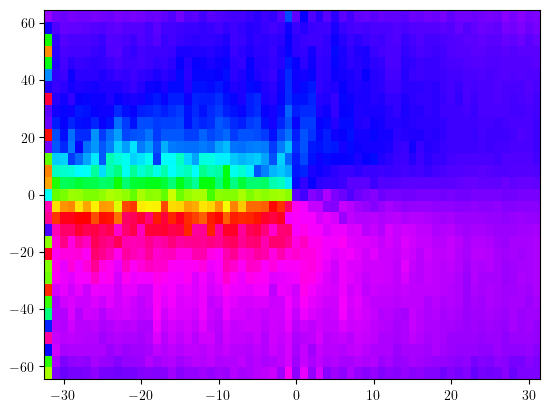

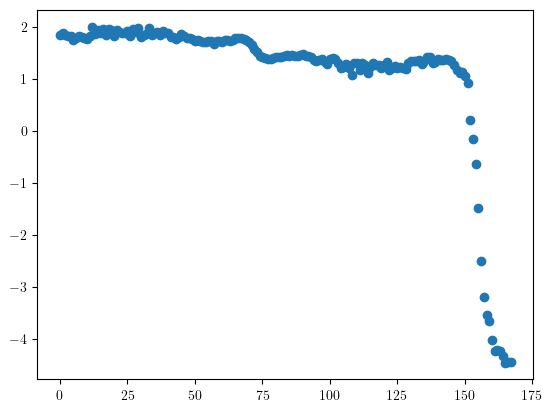

Winding =  -1.0
Step i= 1  (noise = 5 )


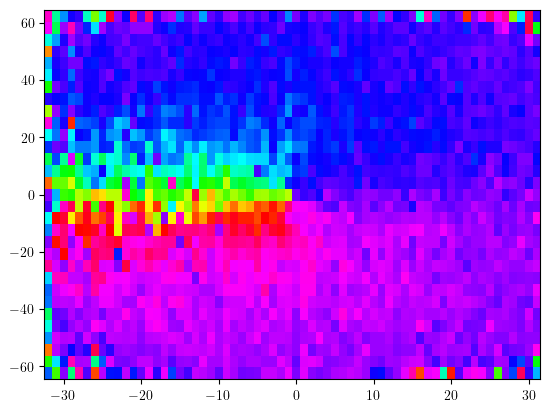

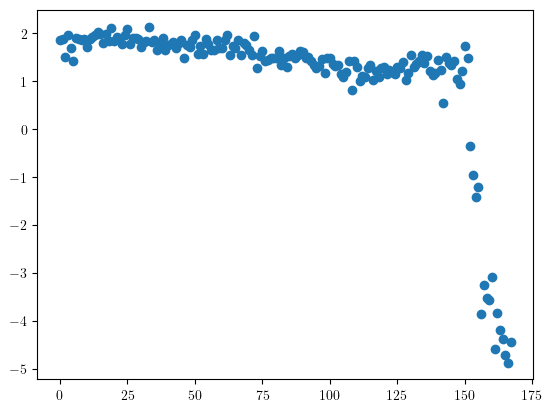

Winding =  -1.0
Step i= 2  (noise = 10 )


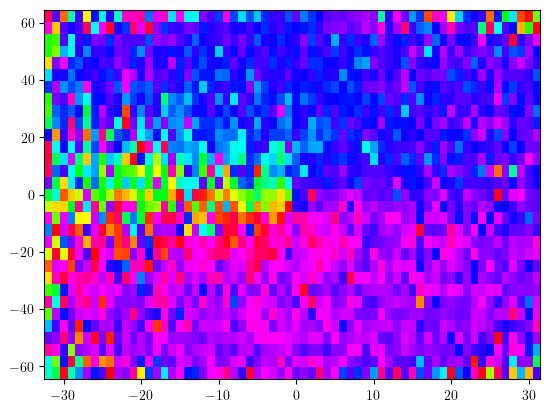

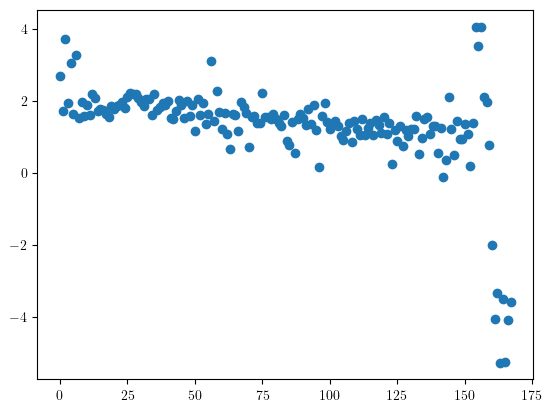

Winding =  -1.0
Done!


In [46]:
noise_amplitudes = (0,5,10)
windings = []

hemisphere = "north"

if hemisphere == "north":
    itheta0 = 0
    itheta1 = np.argmin(np.abs(thetas-np.pi/2))
    
elif hemisphere == "south":
    itheta0 = np.argmin(np.abs(thetas-np.pi/2))+1
    itheta1 = -1  

for i in range(len(noise_amplitudes)):
    ampl_noise = noise_amplitudes[i]
    print("Step i=",i," (noise =",ampl_noise,")")
    full_vx,full_vy,full_vz = noised_fields(ampl_noise,data_vx_txy,data_vy_txy,data_vz_txy)
    spectral_cube_vx, kxs, kys, freqs = spectral_cube(full_vx[:,:,itheta0:itheta1], phis, thetas[itheta0:itheta1], times)
    spectral_cube_vz, kxs, kys, freqs = spectral_cube(full_vz[:,:,itheta0:itheta1], phis, thetas[itheta0:itheta1], times)
    phase = phase_upper_vx_vz(spectral_cube_vx,spectral_cube_vz,freqs)
    full_path, full_path_unwrap, winding = compute_winding(phase,kx0=30,ky0=50)
    windings+=[winding]
    
    kxsm, kysm = np.meshgrid(kxs,kys)
    plt.pcolormesh(kxsm, kysm, phase.T, cmap='hsv')
    plt.show()
    plt.scatter(range(len(full_path)),full_path_unwrap)
    plt.show()
    print("Winding = ",winding)
print("Done!")

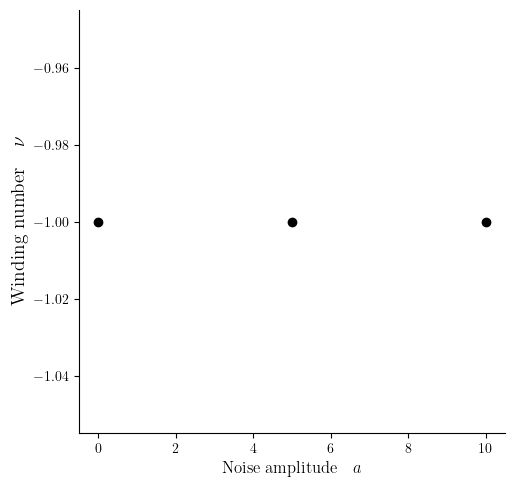

In [47]:
# plot winding-noise

kxsm, kysm = np.meshgrid(kxs,kys)
    
fig,ax = plt.subplots(figsize=(5.5,5.5))
ax=simpleaxis(ax,xlabel=r"$\mathrm{Noise\;amplitude}\quad a$",ylabel=r"$\mathrm{Winding\;number}\quad \nu$",rotation=90)
ax.scatter(noise_amplitudes,windings,c="black")

plt.show()